# EfficientNet
### Reference:
1. [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
2. [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
3. [MnasNet: Platform-Aware Neural Architecture Search for Mobile](https://arxiv.org/abs/1807.11626)
4. [Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

## Building block
Baisically it mainly consists of MBConv also used in MobileNetv2 and it's affected by MnasNet in the study

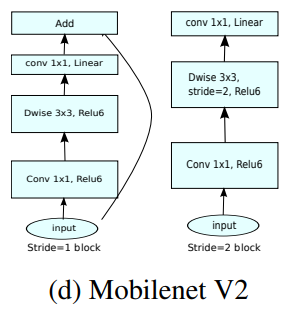

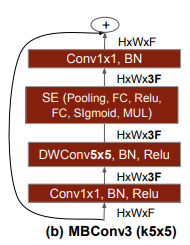

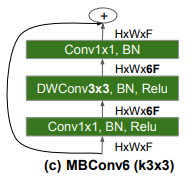

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [7]:
class swish_beta(layers.Activation):
  def __init__(self, beta:int, activation=tf.keras.backend.sigmoid):
    super().__init__(activation)
    self.beta = beta

  def call(self, inputs):
    return 2 * inputs * self.activation(self.beta * inputs)

In [9]:
block_args = [
              {'kernel': (3, 3), 'stride': (1, 1), 'Cout': 16, 'repeat': 1, 'skip': True, 'expand_ratio': 1, 'se_ratio': 0.25},
              {'kernel': (3, 3), 'stride': (1, 1), 'Cout': 24, 'repeat': 2, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              {'kernel': (5, 5), 'stride': (2, 2), 'Cout': 40, 'repeat': 2, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              {'kernel': (3, 3), 'stride': (2, 2), 'Cout': 80, 'repeat': 3, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              {'kernel': (5, 5), 'stride': (2, 2), 'Cout': 112, 'repeat': 3, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              {'kernel': (5, 5), 'stride': (1, 1), 'Cout': 192, 'repeat': 4, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              {'kernel': (3, 3), 'stride': (2, 2), 'Cout': 320, 'repeat': 1, 'skip': True, 'expand_ratio': 6, 'se_ratio': 0.25},
              ]

In [37]:
def mb_conv(X, block_args, layer):
  Cin = X.shape[-1]
  expand = block_args['expand_ratio'] * Cin

  # Expansion phase
  x = layers.Conv2D(filters=expand, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
  x = layers.BatchNormalization(momentum=0.99)(x)
  x = swish_beta(beta=1)(x)
  x = layers.DepthwiseConv2D(kernel_size=block_args['kernel'], strides=block_args['stride'] if layer == 0 else (1, 1), padding='same')(x)
  x = layers.BatchNormalization(momentum=0.99)(x)
  x = swish_beta(beta=1)(x)

  # SE phase
  if 0 < block_args['se_ratio'] <= 1:
    se = layers.GlobalAveragePooling2D(keepdims=True)(x)
    se = layers.Conv2D(filters=int(expand * block_args['se_ratio']), kernel_size=(1, 1), strides=(1, 1), padding='same', activation=swish_beta(beta=1))(se)
    se = layers.Conv2D(filters=expand, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='sigmoid')(se)
    x = layers.multiply([se, x])

  # Squeeze phase
  x = layers.Conv2D(filters=block_args['Cout'], kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization(momentum=0.99)(x)

  # Residual phase
  # case 1: shirnk spatial and expand depth dimension
  # case 2: expand depth dimension only
  # case 3: maintain both dimensions
  if layer == 0:
    if X.shape[1:3] == x.shape[1:3]:
      res = layers.Conv2D(filters=block_args['Cout'], kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
      x = layers.add([res, x])
      return x
    res = layers.Conv2D(filters=block_args['Cout'], kernel_size=(1, 1), strides=(2, 2), padding='same')(X)
    x = layers.add([res, x])
    return x
  else:
    x = layers.add([X, x])
    return x
  


## Efficient-B0 Baseline Network
|$\text{Stage }(i)$|$\text{Operator }(\hat{\mathcal{F}_i})$|$\text{Resolution }(\hat{H}_i\times\hat{W}_i)$|$\text{# Channels }(\hat{C}_i)$|$\text{# Layers }(\hat{L}_i)$|
|:----------:|:---------------------------:|:-------------:|:--------:|:------:|
|$1$         | $\text{Conv }3\times3$      | $224\times224$|$32$      |   $1$  |
|$2$         | $\text{MBConv 1, k}3\times3$|$112\times112$ |$16$      |   $1$  |
|$3$         | $\text{MBConv 6, k}3\times3$|$112\times112$ |$24$      |   $2$  |
|$4$         | $\text{MBConv 6, k}5\times5$| $56\times56$ |$40$      |   $2$  |
|$5$         | $\text{MBConv 6, k}3\times3$| $28\times28$ |$80$      |   $3$  |
|$6$         | $\text{MBConv 6, k}5\times5$| $14\times14$ |$112$     |   $3$  |
|$7$         | $\text{MBConv 6, k}5\times5$| $14\times14$ |$192$     |   $4$  |
|$8$         | $\text{MBConv 6, k}3\times3$|  $7\times7$  |$320$     |   $1$  |
|$9$         | $\text{Conv }1\times1\ \&\text{ Pooling }\&\text{ FC}$ |$7\times7$ |$1280$      |   $1$  |

In [48]:
def efficientnet(block_args):
  inputs = layers.Input(shape=(224, 224, 3))
  x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
  i = 1
  for stage in (block_args):
    for layer in range(stage['repeat']):
      x = mb_conv(x, stage, layer)
  x = layers.Conv2D(filters=1280, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = layers.AveragePooling2D(pool_size=(7, 7), padding='same')(x)
  outputs = layers.Conv2D(filters=1000, kernel_size=(1, 1), strides=(1, 1), activation='softmax')(x)
  model = models.Model(inputs = inputs, outputs=outputs)
  model.summary()

In [49]:
efficientnet(block_args)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_329 (Conv2D)             (None, 112, 112, 32) 896         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_330 (Conv2D)             (None, 112, 112, 32) 1056        conv2d_329[0][0]                 
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 112, 112, 32) 128         conv2d_330[0][0]                 
____________________________________________________________________________________________

## Basic network formula

$
\text{Objective:}\\
\quad max_{d,\ w,\ r}\quad Accuracy(\mathcal{{N}}(d,\ w,\ r))\\
\quad s.t.\quad\quad\quad\  \mathcal{{N}}(d,\ w,\ r)=\bigodot_{i=1\dots{s}}{\mathcal{{F}}_i}^{d\cdot{L_i}}(X_{\langle r\cdot H_i,\ r\cdot W_i,\ w\cdot C_i\rangle}),\quad\text{where }i\text{ is stage index and }L_i\text{ is layer index}\\
\quad\quad\quad\quad\quad\quad \text{Memory}(\mathcal{N})\le\text{target_memory}\\
\quad\quad\quad\quad\quad\quad \text{FLOPS}(\mathcal{N})\le\text{target_flops}
$


## Compound scaling

$
\qquad\text{depth: }d=\alpha^{\phi}\\
\qquad\text{width: }w=\beta^{\phi}\\
\ \text{resolution: }r=\gamma^{\phi}\\
\qquad\quad s.t.\ \alpha\cdot\beta^2\cdot\gamma^2\approx2\\
\qquad\qquad\quad \alpha\ge1,\ \beta\ge1,\ \gamma\ge1\ 
$  
* That is the reason flops is increaseed by $2^{\phi}$ as $\phi$ increase. 
* $\phi$ starts from 1 to 8
* In the study, $\alpha,\ \beta,\ \gamma$ are 1.2, 1.1, 1.15 respectively.

# TODO
Implement Compound scaling